In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [3]:
#loading the dataset
data = pd.read_csv('/kaggle/input/financial-fraud-detection-dataset/Synthetic_Financial_datasets_log.csv')
print(data.head())

print(data.tail())

#gathering information
data.info()

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
         step      type      amount     nameOrig  oldbalanceOrg  \
6362615   743  CASH_OUT   339682.13   

In [4]:
#checking for null values
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
#distrubution of legit and fraud transactions
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [6]:
#seperating the data for analysis
legit_transactions = data[data.isFraud == 0]
Fraud_transactions = data[data.isFraud == 1]
print(legit_transactions.shape)
print(Fraud_transactions.shape)

(6354407, 11)
(8213, 11)


In [8]:
#building sample dataset with same distribution
legit_sample = legit_transactions.sample(n=8213)
new_dataset = pd.concat([legit_sample,Fraud_transactions], axis=0)

In [9]:
new_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1925256,167,PAYMENT,9756.00,C1892142490,30172.0,20416.0,M1632084222,0.00,0.0,0,0
4186497,305,PAYMENT,34239.08,C1627200641,30967.0,0.0,M966693672,0.00,0.0,0,0
1265937,135,CASH_OUT,404365.30,C1912651986,10584.0,0.0,C1493678204,0.00,404365.3,0,0
3321098,253,PAYMENT,43665.10,C1340946943,296.0,0.0,M890349762,0.00,0.0,0,0
5667190,396,TRANSFER,1451667.06,C1039939982,62648.0,0.0,C2137419592,125491.74,1577158.8,0,0


In [10]:
new_dataset = new_dataset.drop(['nameOrig', 'nameDest','type'], axis=1)

In [11]:
new_dataset['isFraud'].value_counts()

isFraud
0    8213
1    8213
Name: count, dtype: int64

In [12]:
new_dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1925256,167,9756.00,30172.0,20416.0,0.00,0.0,0,0
4186497,305,34239.08,30967.0,0.0,0.00,0.0,0,0
1265937,135,404365.30,10584.0,0.0,0.00,404365.3,0,0
3321098,253,43665.10,296.0,0.0,0.00,0.0,0,0
5667190,396,1451667.06,62648.0,0.0,125491.74,1577158.8,0,0


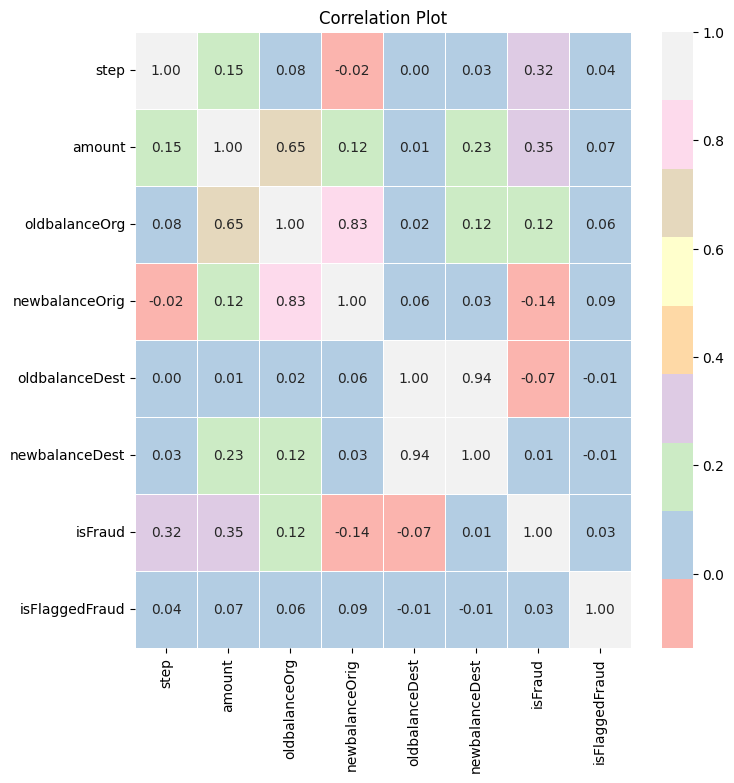

In [13]:
#Visulaization
#correlation plot
corr = new_dataset.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap='Pastel1', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')
plt.show()

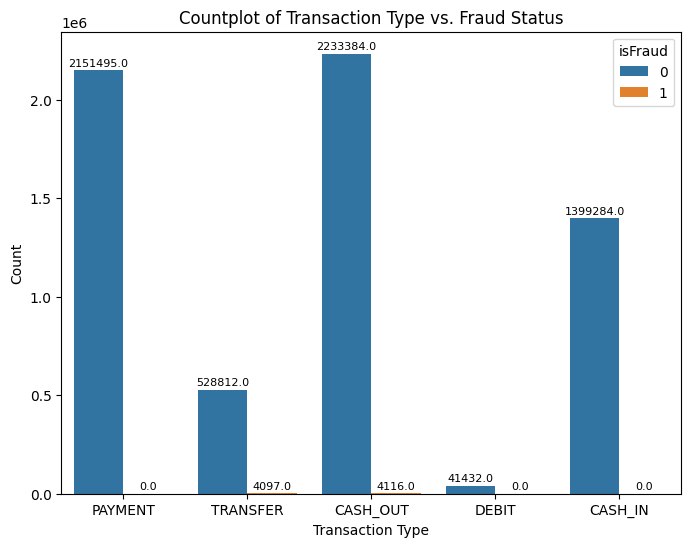

In [14]:
#Count Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=data, x='type', hue='isFraud')

# Adding count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Countplot of Transaction Type vs. Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

In [15]:
#feeding the data 
X = new_dataset.drop(columns = 'isFraud', axis=1)
Y = new_dataset['isFraud']
print(X)
print(Y)

         step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
1925256   167     9756.00       30172.00         20416.0            0.00   
4186497   305    34239.08       30967.00             0.0            0.00   
1265937   135   404365.30       10584.00             0.0            0.00   
3321098   253    43665.10         296.00             0.0            0.00   
5667190   396  1451667.06       62648.00             0.0       125491.74   
...       ...         ...            ...             ...             ...   
6362615   743   339682.13      339682.13             0.0            0.00   
6362616   743  6311409.28     6311409.28             0.0            0.00   
6362617   743  6311409.28     6311409.28             0.0        68488.84   
6362618   743   850002.52      850002.52             0.0            0.00   
6362619   743   850002.52      850002.52             0.0      6510099.11   

         newbalanceDest  isFlaggedFraud  
1925256            0.00               0  
418

In [16]:
#spliting the data into testing and training

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,
                                                    stratify = Y, random_state = 2)
print(X.shape, X_train.shape, X_test.shape)

X_train.info()


(16426, 7) (13140, 7) (3286, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 13140 entries, 2089415 to 438142
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            13140 non-null  int64  
 1   amount          13140 non-null  float64
 2   oldbalanceOrg   13140 non-null  float64
 3   newbalanceOrig  13140 non-null  float64
 4   oldbalanceDest  13140 non-null  float64
 5   newbalanceDest  13140 non-null  float64
 6   isFlaggedFraud  13140 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 821.2 KB


In [17]:
#Model training
model = LogisticRegression()

#training the data with training data
model.fit(X_train, Y_train)

LogisticRegression()

In [18]:
#model evalution
X_train_prediction = model.predict (X_train)
train_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print('Accuracy on training data:', train_data_accuracy)

X_test_prediction = model.predict (X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy on testing data:', test_data_accuracy)

Accuracy on training data: 0.9069254185692542
Accuracy on testing data: 0.8977480219111381


In [19]:
#also,perfoming cross-validation on the same model. 

model = LogisticRegression(max_iter=1000)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_test, Y_test, cv=kf)
print("Cross-Validation Scores:", scores)

mean_score = np.mean(scores)
print("Mean Cross-Validation Score:", mean_score)

Cross-Validation Scores: [0.88753799 0.87975647 0.89041096 0.89193303 0.90563166]
Mean Cross-Validation Score: 0.8910540219196588


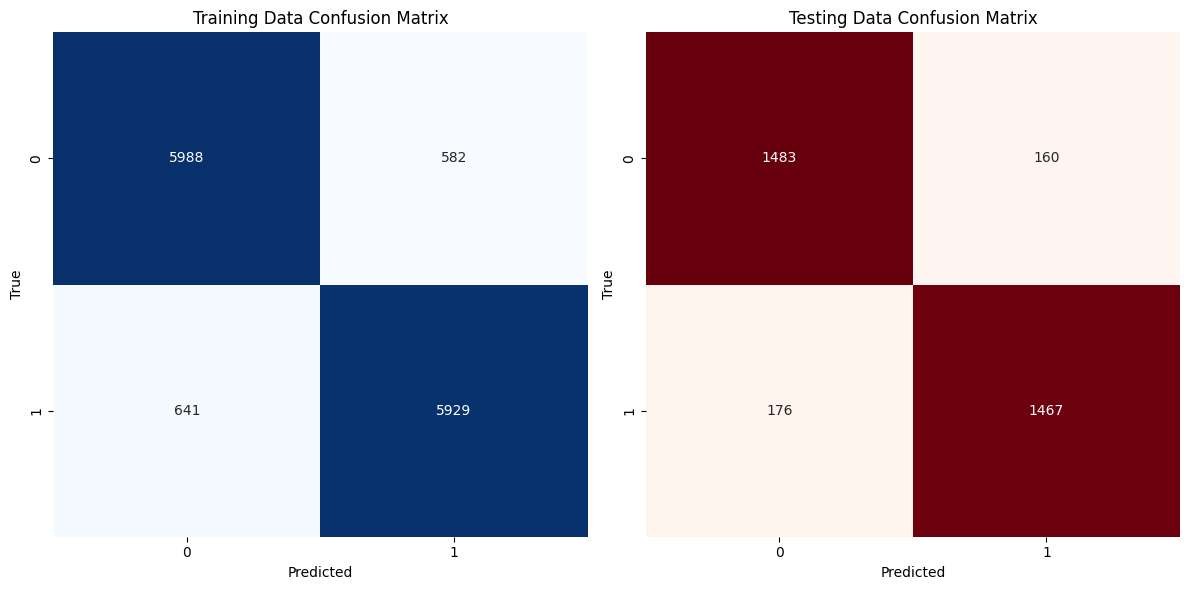

In [20]:
#confusion matrices
train_cm = confusion_matrix(Y_train, X_train_prediction)
test_cm = confusion_matrix(Y_test, X_test_prediction)

#  confusion matrices using  heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.title('Testing Data Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [21]:
#classification report
report = classification_report(Y_test, X_test_prediction)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1643
           1       0.90      0.89      0.90      1643

    accuracy                           0.90      3286
   macro avg       0.90      0.90      0.90      3286
weighted avg       0.90      0.90      0.90      3286



In [22]:
# Also, Using randomforest to predict on the same dataset

model1 = RandomForestClassifier()
model1.fit(X_train, Y_train)

#model evalution
X_train_prediction1 = model1.predict (X_train)
train_data_accuracy1 = accuracy_score(X_train_prediction1, Y_train)

print('Random Forest Accuracy on training data:', train_data_accuracy1)

X_test_prediction1 = model1.predict (X_test)
test_data_accuracy1 = accuracy_score(X_test_prediction1, Y_test)

print('Random Forest Accuracy on testing data:', test_data_accuracy1)

Random Forest Accuracy on training data: 1.0
Random Forest Accuracy on testing data: 0.987522824102252


In [23]:
#perfoming cross val on random forest model
model = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores1 = cross_val_score(model1, X_test, Y_test, cv=kf)
print("Cross-Validation Scores:", scores1)

mean_score1 = np.mean(scores1)
print("Mean Cross-Validation Score:", mean_score1)

Cross-Validation Scores: [0.97416413 0.97716895 0.97108067 0.98173516 0.97716895]
Mean Cross-Validation Score: 0.9762635725620278


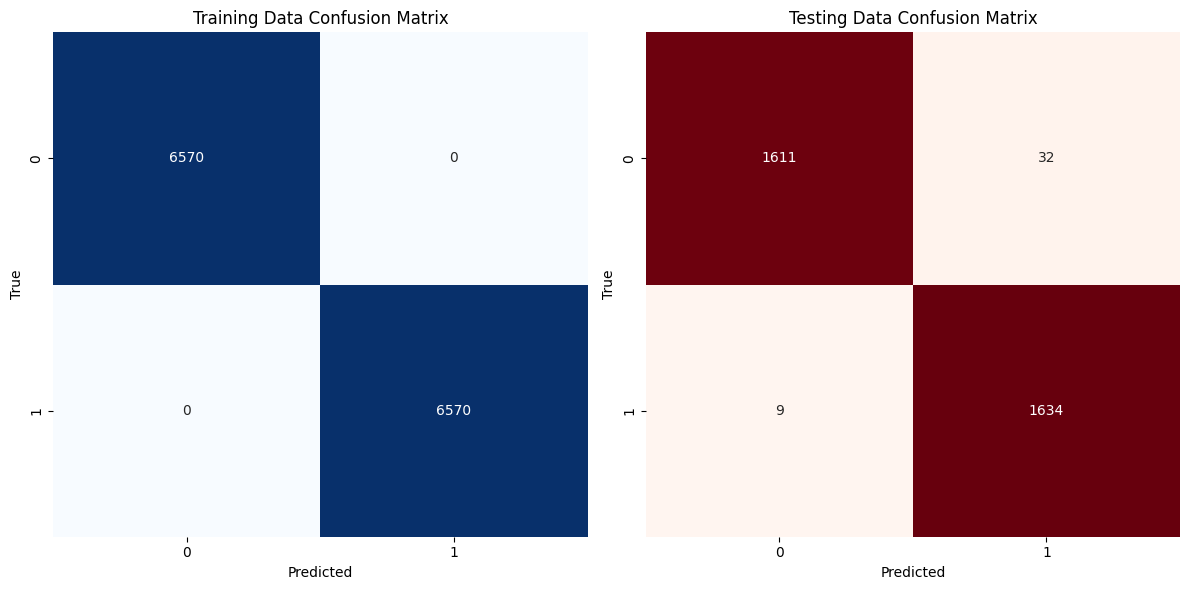

In [24]:
#confusion matrices
train_cm = confusion_matrix(Y_train, X_train_prediction1)
test_cm = confusion_matrix(Y_test, X_test_prediction1)

#  confusion matrices using  heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.title('Testing Data Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()